<a href="https://colab.research.google.com/github/jagrutimohanty/CMPE-258-DeepLearning/blob/main/Assignment7/CMPE_258_Assignment_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Name : Jagruti Mohanty
Assignment 7

# Part B) mnist classification using RNNs where you are passing MNIST image data row by row to rnns



In [ ]:
!pip install watermark

  Found existing installation: importlib-metadata 3.10.1
    Uninstalling importlib-metadata-3.10.1:
      Successfully uninstalled importlib-metadata-3.10.1


# Import MNIST DATA

In [ ]:
mnist = keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
sample, sample_label = x_train[4], y_train[4]

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Model using LSTM layer

In [ ]:
model = keras.Sequential()
# Add an Embedding layer expecting input vocab of size 1000, and
# output embedding dimension of size 64.
model.add(layers.Embedding(input_dim=1000, output_dim=64))

# Add a LSTM layer with 128 internal units.
model.add(layers.LSTM(128))

# Add a Dense layer with 10 units.
model.add(layers.Dense(10))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          64000     
_________________________________________________________________
lstm (LSTM)                  (None, 128)               98816     
_________________________________________________________________
dense (Dense)                (None, 10)                1290      
Total params: 164,106
Trainable params: 164,106
Non-trainable params: 0
_________________________________________________________________


# Model using GRU and simpleRNN

In [ ]:
model = keras.Sequential()
model.add(layers.Embedding(input_dim=1000, output_dim=64))

# The output of GRU will be a 3D tensor of shape (batch_size, timesteps, 256)
model.add(layers.GRU(256, return_sequences=True))

# The output of SimpleRNN will be a 2D tensor of shape (batch_size, 128)
model.add(layers.SimpleRNN(128))

model.add(layers.Dense(10))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 64)          64000     
_________________________________________________________________
gru (GRU)                    (None, None, 256)         247296    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 128)               49280     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 361,866
Trainable params: 361,866
Non-trainable params: 0
_________________________________________________________________


# Model build with RNN(cudnn kernel with LSTM)

In [ ]:
batch_size = 64
# Each MNIST image batch is a tensor of shape (batch_size, 28, 28).
# Each input sequence will be of size (28, 28) (height is treated like time).
input_dim = 28

units = 64
output_size = 10  # labels are from 0 to 9

# Build the RNN model
def build_model(allow_cudnn_kernel=True):
    # CuDNN is only available at the layer level, and not at the cell level.
    # This means `LSTM(units)` will use the CuDNN kernel,
    # while RNN(LSTMCell(units)) will run on non-CuDNN kernel.
    if allow_cudnn_kernel:
        # The LSTM layer with default options uses CuDNN.
        lstm_layer = keras.layers.LSTM(units, input_shape=(None, input_dim))
    else:
        # Wrapping a LSTMCell in a RNN layer will not use CuDNN.
        lstm_layer = keras.layers.RNN(
            keras.layers.LSTMCell(units), input_shape=(None, input_dim)
        )
    model = keras.models.Sequential(
        [
            lstm_layer,
            keras.layers.BatchNormalization(),
            keras.layers.Dense(output_size),
        ]
    )
    return model

In [ ]:
model = build_model(allow_cudnn_kernel=True)

model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer="sgd",
    metrics=["accuracy"],
)


model.fit(
    x_train, y_train, validation_data=(x_test, y_test), batch_size=batch_size, epochs=1
)

938/938 [==============================] - 23s 22ms/step - loss: 1.3583 - accuracy: 0.5645 - val_loss: 0.6980 - val_accuracy: 0.7705


#Output of prediction model

Predicted result is: [9], target result is: 9


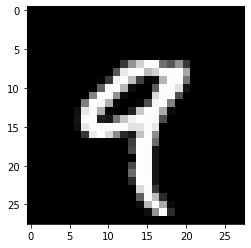

In [ ]:
import matplotlib.pyplot as plt

with tf.device("CPU:0"):
    cpu_model = build_model(allow_cudnn_kernel=True)
    cpu_model.set_weights(model.get_weights())
    result = tf.argmax(cpu_model.predict_on_batch(tf.expand_dims(sample, 0)), axis=1)
    print(
        "Predicted result is: %s, target result is: %s" % (result.numpy(), sample_label)
    )
    plt.imshow(sample, cmap=plt.get_cmap("gray"))

# Part E) Build a timeseries forcasting model using RNN

In [ ]:
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
#Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
#Get the Shareable file link and get the contents
downloaded = drive.CreateFile({'id':"1ntWVLwERS_OVcn1yxIrDtjp05JW1skGZ"})   
downloaded.GetContentFile('TSLA.csv')  

In [ ]:
df=pd.read_csv("TSLA.csv")
#print(‘Number of rows and columns:’, df.shape)
df.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-07-10,52.444000,52.599998,51.563999,51.830002,51.830002,13054500
1,2015-07-13,52.450001,52.509998,51.209999,52.431999,52.431999,14801500
2,2015-07-14,52.419998,53.198002,52.102001,53.130001,53.130001,9538000
3,2015-07-15,53.348000,53.498001,52.416000,52.627998,52.627998,10108000
4,2015-07-16,52.844002,53.439999,52.632000,53.335999,53.335999,8080000


In [ ]:
training_set = df.iloc[:800, 1:2].values
test_set = df.iloc[800:, 1:2].values

In [ ]:
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
# Creating a data structure with 60 time-steps and 1 output
X_train = []
y_train = []
for i in range(60, 800):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
#(740, 60, 1)

In [ ]:
model = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
24/24 [==============================] - 8s 104ms/step - loss: 0.1415
Epoch 2/100
24/24 [==============================] - 3s 111ms/step - loss: 0.0178
Epoch 3/100
24/24 [==============================] - 3s 111ms/step - loss: 0.0155
Epoch 4/100
24/24 [==============================] - 3s 110ms/step - loss: 0.0132
Epoch 5/100
24/24 [==============================] - 3s 111ms/step - loss: 0.0121
Epoch 6/100
24/24 [==============================] - 3s 112ms/step - loss: 0.0133
Epoch 7/100
24/24 [==============================] - 3s 111ms/step - loss: 0.0119
Epoch 8/100
24/24 [==============================] - 3s 111ms/step - loss: 0.0106
Epoch 9/100
24/24 [==============================] - 3s 111ms/step - loss: 0.0098
Epoch 10/100
24/24 [==============================] - 3s 112ms/step - loss: 0.0143
Epoch 11/100
24/24 [==============================] - 3s 112ms/step - loss: 0.0113
Epoch 12/100
24/24 [==============================] - 3s 111ms/step - loss: 0.0110
Epoch 13/100


In [ ]:
# Getting the predicted stock price of 2017
dataset_train = df.iloc[:800, 1:2]
dataset_test = df.iloc[800:, 1:2]
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, 519):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)
# (459, 60, 1)

(459, 60, 1)


In [ ]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

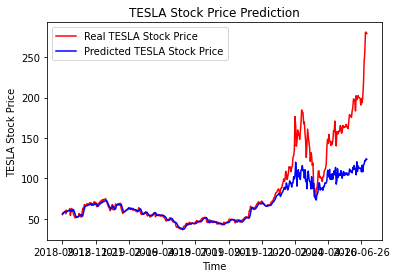

In [ ]:
# Visualising the results
plt.plot(df.loc[800:, 'Date'],dataset_test.values, color = 'red', label = 'Real TESLA Stock Price')
plt.plot(df.loc[800:, 'Date'],predicted_stock_price, color = 'blue', label = 'Predicted TESLA Stock Price')
plt.xticks(np.arange(0,459,50))
plt.title('TESLA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('TESLA Stock Price')
plt.legend()
plt.show()

In [ ]:
X_train = []
y_train = []
for i in range(60, 800):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])

In [ ]:
X_test = []
y_test = []
for i in range(60, 519):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

 # Part C)Build an android studio app using tflite model  for simple colab based trained keras model usecase. 

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls '/content/drive/MyDrive/CMPE-258-Jagruti Mohanty/iris.data'

'/content/drive/MyDrive/CMPE-258-Jagruti Mohanty/iris.data'


In [ ]:


df = pd.read_csv('/content/drive/MyDrive/CMPE-258-Jagruti Mohanty/iris.data',sep=',')

X = df.iloc[:, :4].values
y = df.iloc[:, 4].values

le = LabelEncoder()

y = le.fit_transform(y)
y = to_categorical(y)


from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

model = Sequential()

model.add(Dense(64, activation='relu', input_shape=[4]))
model.add(Dense(64))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer='sgd', loss='categorical_crossentropy',
              metrics=['acc'])


model.fit(X, y, epochs=200)


from tensorflow import lite
converter = lite.TFLiteConverter.from_keras_model(model)

tfmodel = converter.convert()

open('/content/drive/MyDrive/CMPE-258-Jagruti Mohanty/iris.tflite', 'wb').write(tfmodel)

Epoch 1/200
5/5 [==============================] - 0s 3ms/step - loss: 1.6299 - acc: 0.2573
Epoch 2/200
5/5 [==============================] - 0s 3ms/step - loss: 1.1719 - acc: 0.2192
Epoch 3/200
5/5 [==============================] - 0s 3ms/step - loss: 1.1007 - acc: 0.2236
Epoch 4/200
5/5 [==============================] - 0s 2ms/step - loss: 1.0305 - acc: 0.2819
Epoch 5/200
5/5 [==============================] - 0s 4ms/step - loss: 0.9507 - acc: 0.5246
Epoch 6/200
5/5 [==============================] - 0s 2ms/step - loss: 0.9013 - acc: 0.5816
Epoch 7/200
5/5 [==============================] - 0s 4ms/step - loss: 0.8570 - acc: 0.5338
Epoch 8/200
5/5 [==============================] - 0s 3ms/step - loss: 0.7789 - acc: 0.6985
Epoch 9/200
5/5 [==============================] - 0s 2ms/step - loss: 0.7414 - acc: 0.7262
Epoch 10/200
5/5 [==============================] - 0s 2ms/step - loss: 0.7190 - acc: 0.6764
Epoch 11/200
5/5 [==============================] - 0s 2ms/step - loss: 0.6841 

INFO:tensorflow:Assets written to: /tmp/tmpywj3xz0a/assets


20488

# This model is later on used in andriod application the details are shared in github repository

# Part D) Code is updated in github with evidence